# Advanced SQL [2] - Advanced Data Engineering Pipeline

In [30]:
# Import necessary libraries
import os
import zipfile
import sqlite3
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import hashlib
import random
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [32]:
zip_file_path = 'brain_tumor_mri.zip'
extraction_path = ""

In [33]:
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
  zip_ref.extractall(extraction_path)

  for root, dirs, files in os.walk('brain_tumor_mri/'):
    print(root, "contains", len(files), "files and", len(dirs), "dictionaries.")

  train_dir = os.path.join('brain_tumor_mri/', 'training')
  test_dir = os.path.join('brain_tumor_mri/','testing')


brain_tumor_mri/ contains 0 files and 2 dictionaries.
brain_tumor_mri/training contains 0 files and 4 dictionaries.
brain_tumor_mri/training/notumor contains 1595 files and 0 dictionaries.
brain_tumor_mri/training/glioma contains 1321 files and 0 dictionaries.
brain_tumor_mri/training/meningioma contains 1339 files and 0 dictionaries.
brain_tumor_mri/training/pituitary contains 1457 files and 0 dictionaries.
brain_tumor_mri/testing contains 1 files and 4 dictionaries.
brain_tumor_mri/testing/notumor contains 405 files and 0 dictionaries.
brain_tumor_mri/testing/glioma contains 300 files and 0 dictionaries.
brain_tumor_mri/testing/meningioma contains 306 files and 0 dictionaries.
brain_tumor_mri/testing/pituitary contains 300 files and 0 dictionaries.


In [34]:
def calculate_image_hash(image_path):
  with open(image_path, "rb") as f:
    return hashlib.md5(f.read()).hexdigest()

conn = sqlite3.connect('brain_tumor_mri.db')
c = conn.cursor()

c.execute("DROP TABLE IF EXISTS mri_data")

c.execute('''
CREATE TABLE mri_data (
  image_path TEXT PRIMARY KEY,
  label TEXT,
  split TEXT,
  image_hash TEXT
)
''')

def add_images_to_db(directory, split):
  for label in os.listdir(directory):
    label_path = os.path.join(directory, label)
    if os.path.isdir(label_path):
      for img_file in os.listdir(label_path):
        if img_file.endswith(".jpg"):
          img_path = os.path.join(label_path, img_file)
          img_hash = calculate_image_hash(img_path)
          c.execute("INSERT OR IGNORE INTO mri_data (image_path, label, split, image_hash) VALUES (?, ?, ?, ?)",
                    (img_path, label, split, img_hash))

add_images_to_db(train_dir, "train")
add_images_to_db(test_dir,"test")\

conn.commit()


In [35]:
total_counts_df = pd.read_sql_query("SELECT label, COUNT(*) as count FROM mri_data", conn)
display(total_counts_df)

,label,count
0,notumor,7023


In [36]:
label_counts_df = pd.read_sql_query("SELECT label, COUNT(*) as count FROM mri_data GROUP BY label", conn)
display(label_counts_df)

,label,count
0,glioma,1621
1,meningioma,1645
2,notumor,2000
3,pituitary,1757


In [37]:
split_counts_df = pd.read_sql_query("SELECT split, COUNT(*) as count FROM mri_data GROUP BY split", conn)
display(split_counts_df)

,split,count
0,test,1311
1,train,5712


In [38]:
inital_data_df = pd.read_sql_query("SELECT * FROM mri_data LIMIT 5", conn)
display(inital_data_df)

,image_path,label,split,image_hash
0,brain_tumor_mri/training/notumor/Tr-no_0440.jpg,notumor,train,f75f2a80d34787fdcc2ee44622f21460
1,brain_tumor_mri/training/notumor/Tr-no_0722.jpg,notumor,train,72e638d7e6895d1b61ea8d6e7c879cfb
2,brain_tumor_mri/training/notumor/Tr-no_1478.jpg,notumor,train,e43cc3022533c898b30efba4a989e239
3,brain_tumor_mri/training/notumor/Tr-no_1053.jpg,notumor,train,2425479e1c8ff8a4f2f852c5e6957dad
4,brain_tumor_mri/training/notumor/Tr-no_1509.jpg,notumor,train,59c81b7ba29b994e5b855d7f2bfc3bb5


In [39]:
initial_hash_counts_df = pd.read_sql_query("SELECT image_hash, COUNT(*) as count FROM mri_data GROUP BY image_hash HAVING count > 1", conn)
display(initial_hash_counts_df)

,image_hash,count
0,04ad12436c5b59dac34ff27b48e8dd9a,3
1,05c3caea567ffd77caf79c12654b87e5,3
2,05fe39a899414d2dab6cad25c301b32c,2
3,06c3e21e888012e7845da47b26b742e8,2
4,0abe34033d22367d0fe55445050a6f7e,2
...,...,...
189,f4b4f54022e5d07d1cfecf6868492299,3
190,f6a666f3aad6223c98e59c677b06310c,2
191,fc6ff0af19a89f3e2c2c4b1d7f5b9dc6,5
192,fdea69d8f1eaf6ad0933a4e4ba3cc4f6,2


In [40]:
c.execute('''
DELETE FROM mri_data
WHERE rowid NOT IN (
  SELECT MIN(rowid)
  FROM mri_data
  GROUP BY image_hash
)
''')

conn.commit()

In [41]:
dedup_hash_counts = pd.read_sql_query("SELECT image_hash, COUNT(*) as count FROM mri_data GROUP BY image_hash HAVING count > 1", conn)
display(dedup_hash_counts)

,image_hash,count


In [42]:
try:
  c.execute('ALTER TABLE mri_data ADD COLUMN file_name_length INTEGER')
except:
  print("Column already exists buddy!")

c.execute('''
UPDATE mri_data
SET file_name_length = LENGTH(image_path) - LENGTH(REPLACE(image_path, '/', '')) - LENGTH(SUBSTR(image_path, 0, INSTR(image_path, '/')))
''')

conn.commit()

In [43]:
file_name_length_df = pd.read_sql_query("SELECT image_path, file_name_length FROM mri_data LIMIT 5", conn)
display(file_name_length_df)

,image_path,file_name_length
0,brain_tumor_mri/training/notumor/Tr-no_0440.jpg,-12
1,brain_tumor_mri/training/notumor/Tr-no_0722.jpg,-12
2,brain_tumor_mri/training/notumor/Tr-no_1478.jpg,-12
3,brain_tumor_mri/training/notumor/Tr-no_1053.jpg,-12
4,brain_tumor_mri/training/notumor/Tr-no_1509.jpg,-12


In [44]:
file_name_length_dist_df = pd.read_sql_query("SELECT file_name_length, COUNT(*) as count FROM mri_data GROUP BY file_name_length", conn)
display(file_name_length_dist_df)

,file_name_length,count
0,-12,6726


In [45]:
total_counts_df = pd.read_sql_query("SELECT label, COUNT(*) FROM mri_data GROUP BY label", conn)
display(total_counts_df)

,label,COUNT(*)
0,glioma,1620
1,meningioma,1635
2,notumor,1731
3,pituitary,1740


In [46]:
label_counts_df = pd.read_sql_query("SELECT label, COUNT(*) FROM mri_data GROUP BY label", conn)
display(label_counts_df)

,label,COUNT(*)
0,glioma,1620
1,meningioma,1635
2,notumor,1731
3,pituitary,1740


In [47]:
split_counts_df = pd.read_sql_query("SELECT split, COUNT(*) FROM mri_data GROUP BY split", conn)
display(split_counts_df)

,split,COUNT(*)
0,test,1205
1,train,5521


In [48]:
df = pd.read_sql_query("SELECT * FROM mri_data", conn)

conn.close()

df.head()

,image_path,label,split,image_hash,file_name_length
0,brain_tumor_mri/training/notumor/Tr-no_0440.jpg,notumor,train,f75f2a80d34787fdcc2ee44622f21460,-12
1,brain_tumor_mri/training/notumor/Tr-no_0722.jpg,notumor,train,72e638d7e6895d1b61ea8d6e7c879cfb,-12
2,brain_tumor_mri/training/notumor/Tr-no_1478.jpg,notumor,train,e43cc3022533c898b30efba4a989e239,-12
3,brain_tumor_mri/training/notumor/Tr-no_1053.jpg,notumor,train,2425479e1c8ff8a4f2f852c5e6957dad,-12
4,brain_tumor_mri/training/notumor/Tr-no_1509.jpg,notumor,train,59c81b7ba29b994e5b855d7f2bfc3bb5,-12


In [49]:
train_df = df[df['split']=='train']
test_df = df[df['split']=='test']

print("Training data size:", len(train_df))
print("Testing data size:", len(test_df))

Training data size: 5521
Testing data size: 1205


In [50]:
unique_labels = train_df['label'].unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
inverse_label_mapping = {idx: label for label, idx in label_mapping.items()}

print(label_mapping)

{'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}


In [51]:
class BrainTumorDataset(Dataset):
  def __init__(self, dataframe, transform = None):
    self.dataframe = dataframe
    self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx]['image_path']
    image = Image.open(img_path).convert('RGB')
    label = label_mapping[self.dataframe.iloc[idx, 1]]

    if self.transform:
      image = self.transform(image)

    return image, label

transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
])

In [52]:
train_df, test_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

train_dataset = BrainTumorDataset(train_df, transform=transform)
test_dataset = BrainTumorDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [55]:
class TumorClassifier(nn.Module):
  def __init__(self, num_classes):
    super(TumorClassifier, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding = 0)
    self.fc1 = nn.Linear(64 * 56 * 56, 128)
    self.fc2 = nn.Linear(128, len(label_mapping))

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    self.features = x
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 64 * 56 * 56)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Get the number of classes from the label_mapping
num_classes = len(label_mapping)
# Pass num_classes to the TumorClassifier constructor
model = TumorClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct_predictions = 0
  total_predictions = 0 # Initialize total_predictions here

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)
    correct_predictions += (predicted == labels).sum().item()
    total_predictions += labels.size(0)

  epoch_loss = running_loss / len(train_loader)
  epoch_accuracy = correct_predictions / total_predictions * 100

  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch 1/5, Loss: 0.6545, Accuracy: 75.07%
Epoch 2/5, Loss: 0.2868, Accuracy: 89.52%
Epoch 3/5, Loss: 0.1722, Accuracy: 93.43%
Epoch 4/5, Loss: 0.0938, Accuracy: 96.54%
Epoch 5/5, Loss: 0.0574, Accuracy: 98.14%


In [57]:
model_path = "Tumor_classifier.pth"
torch.save(model.state_dict(), model_path)

In [68]:
def visualize_prediction(test_df, model, label_mapping, inverse_label_mapping):
  model.eval()

  random_idx = random.randint(0, len(test_df) - 1)
  image_path = test_df.iloc[random_idx]['image_path']
  image = Image.open(image_path).convert('RGB')
  image = transform(image).unsqueeze(0).to(device)

  with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted_label_idx = predicted.item()
    predicted_label = inverse_label_mapping[predicted_label_idx]

  # Move the image tensor to CPU before displaying it
  image_np = image.cpu().squeeze(0).permute(1, 2, 0).numpy()

  plt.imshow(image_np)  # Display the NumPy array
  plt.title(f"Predicted Tumor Type: {predicted_label}")
  plt.axis('off')
  plt.show()

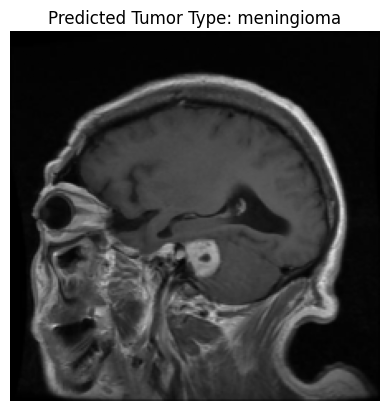

In [71]:
visualize_prediction(test_df, model, label_mapping, inverse_label_mapping)

1. Defined parameters of the neural network.

2. Training for 5 epochs

3. Saved the model

4. Load the model

5. Performed visualisation